# Traffic Data

In [1]:
#%matplotlib inline 
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import h3 as h3  
import pyarrow as pa 
import pyarrow.parquet as pq
import geopandas as gpd 
import geoplot as gpt
from datetime import datetime, timedelta

## 1. Import and clean data
- In this section the imported data will be cleaned. And new features will be created

In [2]:
waze_data = pd.read_csv('waze_jams_20190101_20200630.csv') 
waze_data

,bbox,city,country,delay,endNode,endnode,entity_id,entity_location,entity_ts,entity_type,...,pubMillis,pubmillis,roadType,roadtype,street,turnType,turntype,typeEntity,typeentity,validity_ts
0,"-9.149844,38.738675,-9.148286,38.738913",Lisboa {Avenidas Novas},PO,-1.0,NULL,Av. 5 de Outubro,EMEL.waze.jams.2107486134,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0.0,1.545930e+12,0.0,1.0,Av. Elias Garcia,NULL,NONE,NULL,NONE,1.546301e+12
1,"-9.202781,38.734172,-9.202317,38.734343",Lisboa {Alto da Boavista},PO,-1.0,NULL,Est. do Outeiro,EMEL.waze.jams.1491397219,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0.0,1.545360e+12,0.0,1.0,NULL,NULL,NONE,NULL,NONE,1.546301e+12
2,"-9.201714,38.70103,-9.200505,38.701452",Lisboa {Ajuda},PO,-1.0,NULL,R. Gen. Massano de Amorim,EMEL.waze.jams.1898239485,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0.0,1.545710e+12,0.0,1.0,R. Gen. João de Almeida,NULL,NONE,NULL,NONE,1.546301e+12
3,"-9.147109,38.729467,-9.145892,38.729919",Lisboa {Picoas},PO,-1.0,NULL,Av. Fontes Pereira de Melo,EMEL.waze.jams.1898098006,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0.0,1.545710e+12,0.0,1.0,R. Andrade Corvo,NULL,NONE,NULL,NONE,1.546301e+12
4,"-9.137746,38.743447,-9.13385,38.744505",Lisboa {S. João de Deus},PO,62.0,NULL,Av. de S. João de Deus,EMEL.waze.jams.297357948,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0.0,1.546300e+12,0.0,1.0,Av. de Madrid,NULL,NONE,NULL,NONE,1.546301e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12619455,"-9.158017,38.738714,-9.157551,38.738906",Lisboa,PO,-1.0,NULL,Av. Santos Dumont,EMEL.waze.jams.566407993,"[0.0, 0.0]",1.593561e+12,EMEL.waze.jams,...,0.0,1.593510e+12,0.0,7.0,Pç. de Espanha,NULL,NONE,NULL,NONE,1.593562e+12
12619456,"-9.176146,38.737044,-9.17216,38.740176",NaN,PO,-1.0,NULL,Bairro das Furnas {Lisboa},EMEL.waze.jams.439491469,"[0.0, 0.0]",1.593561e+12,EMEL.waze.jams,...,0.0,1.593550e+12,0.0,4.0,Av. Gen. Correia Barreto / Radial de Benfica,NULL,NONE,NULL,NONE,1.593562e+12
12619457,"-9.132514,38.723625,-9.131763,38.72429",Lisboa,PO,-1.0,NULL,R. Antónia Andrade,EMEL.waze.jams.1698807952,"[0.0, 0.0]",1.593561e+12,EMEL.waze.jams,...,0.0,1.592430e+12,0.0,1.0,R. do Forno do Tijolo,NULL,NONE,NULL,NONE,1.593562e+12
12619458,"-9.14363,38.749467,-9.14292,38.74961",Lisboa,PO,-1.0,NULL,NULL,EMEL.waze.jams.406743189,"[0.0, 0.0]",1.593561e+12,EMEL.waze.jams,...,0.0,1.593510e+12,0.0,20.0,NULL,NULL,NONE,NULL,NONE,1.593562e+12


### 1.1. Clean and transform

-Drop the rows with NaN values at 'street', 'entity_ts', 'bbox' and  'delay' columns (since these ones are of keen interest to characterize the traffic)

In [3]:
waze_data_nNaN = waze_data.drop(waze_data.loc[waze_data['street'].isna()==True].index) 
waze_data_nNaN = waze_data_nNaN.drop(waze_data_nNaN.loc[waze_data_nNaN['entity_ts'].isna()==True].index)  
waze_data_nNaN = waze_data_nNaN.drop(waze_data_nNaN.loc[waze_data_nNaN['delay'].isna()==True].index)  
waze_data_nNaN = waze_data_nNaN.drop(waze_data_nNaN.loc[waze_data_nNaN['bbox'].isna()==True].index) 

-Transform the entity_ts column to date time format aaaa-mm-dd hh:mm:ss.ms. Create year, month, hour and minute features

In [4]:
waze_data_nNaN['data_hora']=pd.to_datetime(waze_data_nNaN.entity_ts,unit='ms') 
waze_data_nNaN['Minutes'] = waze_data_nNaN['data_hora'].dt.minute 
waze_data_nNaN['Hours'] = waze_data_nNaN['data_hora'].dt.hour 
waze_data_nNaN['Months'] = waze_data_nNaN['data_hora'].dt.month
waze_data_nNaN['Years'] = waze_data_nNaN['data_hora'].dt.year 

-Drop all the lines respective to 2020 year

In [5]:
waze_data_nNaN = waze_data_nNaN.drop(waze_data_nNaN.loc[waze_data_nNaN['Years']==2020].index)

-Create a new date_time format, aaaa-mm-dd hh:mm

In [6]:
waze_data_nNaN['data_hora_2'] = waze_data_nNaN['data_hora'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d %H:%M'))

In [2]:
waze_data_nNaN['data_hora_2']= waze_data_nNaN['data_hora_2'].astype('datetime64[ns]')  

NameError: name 'waze_data_nNaN' is not defined

### 1.2. Create and transform the coordinates features

-Obtain coordinates features (Latitude and Longitude)

In [8]:
## Longitude
longitude = waze_data_nNaN['bbox'].str.split(',').str[0].astype(float) 
waze_data_nNaN['Longitude'] = longitude 

## Latitude
latitude = waze_data_nNaN['bbox'].str.split(',').str[1].astype(float)
waze_data_nNaN['Latitude'] = latitude

-Calculate the respective h3 points for each coordinate

In [9]:
h3_point= list()
for i in range(0, latitude.shape[0]):
    h3_point.insert(i, h3.geo_to_h3(latitude[i], longitude[i], 8)) 

-Transform the coordinates into strings and concatenate the latitude and longitude features

In [10]:
## Longitude
longitude_2 = waze_data_nNaN['bbox'].str.split(',').str[0] 
waze_data_nNaN['Longitude_2'] = longitude_2 

## Latitude
latitude_2 = waze_data_nNaN['bbox'].str.split(',').str[1]
waze_data_nNaN['Latitude_2'] = latitude_2 

waze_data_nNaN['Coordinates'] = waze_data_nNaN['Latitude_2'] +',' + waze_data_nNaN['Longitude_2'] 

In [11]:
waze_data_nNaN['H3_point'] = h3_point  
waze_data_nNaN

,bbox,city,country,delay,endNode,endnode,entity_id,entity_location,entity_ts,entity_type,...,Hours,Months,Years,data_hora_2,Longitude,Latitude,Longitude_2,Latitude_2,Coordinates,H3_point
0,"-9.149844,38.738675,-9.148286,38.738913",Lisboa {Avenidas Novas},PO,-1.0,NULL,Av. 5 de Outubro,EMEL.waze.jams.2107486134,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0,1,2019,2019-01-01 00:02:00,-9.149844,38.738675,-9.149844,38.738675,"38.738675,-9.149844",8839336291fffff
1,"-9.202781,38.734172,-9.202317,38.734343",Lisboa {Alto da Boavista},PO,-1.0,NULL,Est. do Outeiro,EMEL.waze.jams.1491397219,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0,1,2019,2019-01-01 00:02:00,-9.202781,38.734172,-9.202781,38.734172,"38.734172,-9.202781",88393362ebfffff
2,"-9.201714,38.70103,-9.200505,38.701452",Lisboa {Ajuda},PO,-1.0,NULL,R. Gen. Massano de Amorim,EMEL.waze.jams.1898239485,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0,1,2019,2019-01-01 00:02:00,-9.201714,38.701030,-9.201714,38.70103,"38.70103,-9.201714",8839336053fffff
3,"-9.147109,38.729467,-9.145892,38.729919",Lisboa {Picoas},PO,-1.0,NULL,Av. Fontes Pereira de Melo,EMEL.waze.jams.1898098006,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0,1,2019,2019-01-01 00:02:00,-9.147109,38.729467,-9.147109,38.729467,"38.729467,-9.147109",8839336297fffff
4,"-9.137746,38.743447,-9.13385,38.744505",Lisboa {S. João de Deus},PO,62.0,NULL,Av. de S. João de Deus,EMEL.waze.jams.297357948,"[0.0, 0.0]",1.546301e+12,EMEL.waze.jams,...,0,1,2019,2019-01-01 00:02:00,-9.137746,38.743447,-9.137746,38.743447,"38.743447,-9.137746",883933629bfffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8422313,"-9.237425,38.696247,-9.236346,38.697531",NaN,PO,-1.0,NULL,Dafundo,EMEL.waze.jams.1059208286,"[0.0, 0.0]",1.577837e+12,EMEL.waze.jams,...,23,12,2019,2019-12-31 23:56:00,-9.237425,38.696247,-9.237425,38.696247,"38.696247,-9.237425",8839336041fffff
8422314,"-9.150635,38.726147,-9.150359,38.726361",Lisboa,PO,-1.0,NULL,NULL,EMEL.waze.jams.1199994929,"[0.0, 0.0]",1.577837e+12,EMEL.waze.jams,...,23,12,2019,2019-12-31 23:56:00,-9.150635,38.726147,-9.150635,38.726147,"38.726147,-9.150635",8839336295fffff
8422315,"-9.229924,38.696816,-9.229676,38.697272",NaN,PO,-1.0,NULL,Algés,EMEL.waze.jams.78537674,"[0.0, 0.0]",1.577837e+12,EMEL.waze.jams,...,23,12,2019,2019-12-31 23:56:00,-9.229924,38.696816,-9.229924,38.696816,"38.696816,-9.229924",8839336043fffff
8422316,"-9.150922,38.726131,-9.150635,38.72624",Lisboa {St. António},PO,-1.0,NULL,Al. Edgar Cardoso [BUS],EMEL.waze.jams.1815166131,"[0.0, 0.0]",1.577837e+12,EMEL.waze.jams,...,23,12,2019,2019-12-31 23:56:00,-9.150922,38.726131,-9.150922,38.726131,"38.726131,-9.150922",8839336295fffff


## 2. Traffic Indicator  
-In this section the delay feature will be grouped by respective coordinates (lat, long) and by h3 coordinates, by minute. The delay feature is considered the traffic value. The delay will be also grouped by ohter features for exploration purposes.

### 2.1. Create and clean a sub dataframe the considers only the main features used for the next analysis

In [12]:
waze_data_ind = waze_data_nNaN[['street', 'H3_point','position', 'Longitude', 'Latitude', 'data_hora_2', 'delay', 'Coordinates', 'Hours', 'Months']] 
waze_data_ind = waze_data_ind.drop(waze_data_ind.loc[waze_data_ind['street']==' NULL'].index) 
waze_data_ind

,street,H3_point,position,Longitude,Latitude,data_hora_2,delay,Coordinates,Hours,Months
0,Av. Elias Garcia,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.149844,38.738675,2019-01-01 00:02:00,-1.0,"38.738675,-9.149844",0,1
2,R. Gen. João de Almeida,8839336053fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.201714,38.701030,2019-01-01 00:02:00,-1.0,"38.70103,-9.201714",0,1
3,R. Andrade Corvo,8839336297fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.147109,38.729467,2019-01-01 00:02:00,-1.0,"38.729467,-9.147109",0,1
4,Av. de Madrid,883933629bfffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.137746,38.743447,2019-01-01 00:02:00,62.0,"38.743447,-9.137746",0,1
5,R. Pinheiro Chagas,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.146687,38.732499,2019-01-01 00:02:00,-1.0,"38.732499,-9.146687",0,1
...,...,...,...,...,...,...,...,...,...,...
8422312,R. de S. Paulo,88393360d9fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.143321,38.707269,2019-12-31 23:56:00,-1.0,"38.707269,-9.143321",23,12
8422314,Ac. € [P] EMPARK - Mq. de Pombal,8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150635,38.726147,2019-12-31 23:56:00,-1.0,"38.726147,-9.150635",23,12
8422315,Av. Dr. Alfredo Magalhães Ramalho,8839336043fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.229924,38.696816,2019-12-31 23:56:00,-1.0,"38.696816,-9.229924",23,12
8422316,[BUS],8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150922,38.726131,2019-12-31 23:56:00,-1.0,"38.726131,-9.150922",23,12


-Transform the "-1" delay values into zero

In [13]:
waze_data_ind.loc[waze_data_ind['delay'] == -1, 'delay']=0 
waze_data_ind

,street,H3_point,position,Longitude,Latitude,data_hora_2,delay,Coordinates,Hours,Months
0,Av. Elias Garcia,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.149844,38.738675,2019-01-01 00:02:00,0.0,"38.738675,-9.149844",0,1
2,R. Gen. João de Almeida,8839336053fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.201714,38.701030,2019-01-01 00:02:00,0.0,"38.70103,-9.201714",0,1
3,R. Andrade Corvo,8839336297fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.147109,38.729467,2019-01-01 00:02:00,0.0,"38.729467,-9.147109",0,1
4,Av. de Madrid,883933629bfffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.137746,38.743447,2019-01-01 00:02:00,62.0,"38.743447,-9.137746",0,1
5,R. Pinheiro Chagas,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.146687,38.732499,2019-01-01 00:02:00,0.0,"38.732499,-9.146687",0,1
...,...,...,...,...,...,...,...,...,...,...
8422312,R. de S. Paulo,88393360d9fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.143321,38.707269,2019-12-31 23:56:00,0.0,"38.707269,-9.143321",23,12
8422314,Ac. € [P] EMPARK - Mq. de Pombal,8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150635,38.726147,2019-12-31 23:56:00,0.0,"38.726147,-9.150635",23,12
8422315,Av. Dr. Alfredo Magalhães Ramalho,8839336043fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.229924,38.696816,2019-12-31 23:56:00,0.0,"38.696816,-9.229924",23,12
8422316,[BUS],8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150922,38.726131,2019-12-31 23:56:00,0.0,"38.726131,-9.150922",23,12


In [14]:
Coord_group = waze_data_ind.groupby(['Longitude', 'Latitude'])['delay'].mean().reset_index() 
Coord_group

,Longitude,Latitude,delay
0,-9.288885,38.713611,1014.222222
1,-9.288885,38.713642,791.310345
2,-9.286448,38.713611,872.300000
3,-9.286448,38.713642,824.712963
4,-9.281103,38.713611,1112.000000
...,...,...,...
21718,-9.092583,38.771710,103.444444
21719,-9.092567,38.771709,135.596154
21720,-9.092440,38.773497,0.000000
21721,-9.092408,38.773497,0.243647


-Identifying outliers in delay values

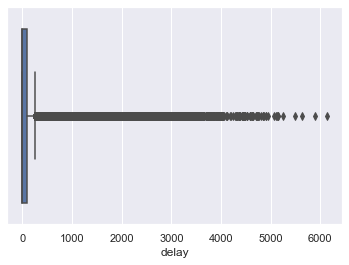

In [15]:
ax = sns.boxplot(x=waze_data_ind["delay"])

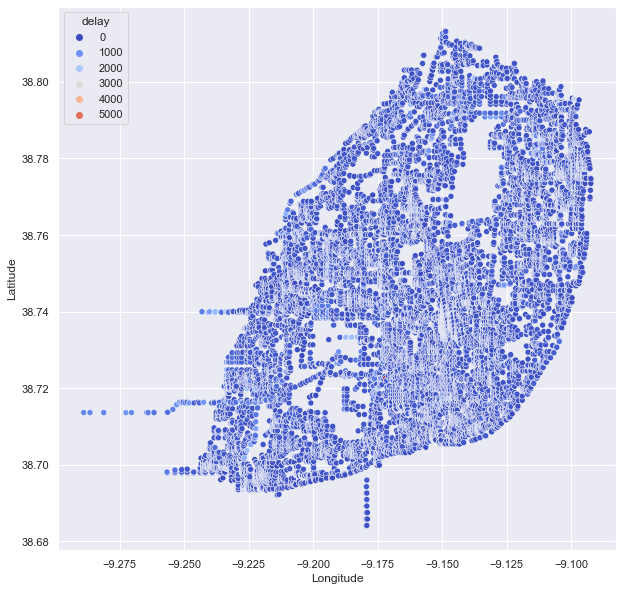

In [73]:
pallete_1= sns.color_palette("coolwarm", as_cmap=True) 
plt.figure(figsize=(10, 10))
sns.scatterplot(data=Coord_group, y='Latitude', x='Longitude', hue='delay', palette=pallete_1)
ax.set_facecolor("white")

#### The rows with delay outliers values were removed  

In [16]:
waze_data_ind_5000 = waze_data_ind.loc[(waze_data_ind['delay'] <= 5000)].reset_index()   
waze_data_ind_5000

,index,street,H3_point,position,Longitude,Latitude,data_hora_2,delay,Coordinates,Hours,Months
0,0,Av. Elias Garcia,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.149844,38.738675,2019-01-01 00:02:00,0.0,"38.738675,-9.149844",0,1
1,2,R. Gen. João de Almeida,8839336053fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.201714,38.701030,2019-01-01 00:02:00,0.0,"38.70103,-9.201714",0,1
2,3,R. Andrade Corvo,8839336297fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.147109,38.729467,2019-01-01 00:02:00,0.0,"38.729467,-9.147109",0,1
3,4,Av. de Madrid,883933629bfffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.137746,38.743447,2019-01-01 00:02:00,62.0,"38.743447,-9.137746",0,1
4,5,R. Pinheiro Chagas,8839336291fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.146687,38.732499,2019-01-01 00:02:00,0.0,"38.732499,-9.146687",0,1
...,...,...,...,...,...,...,...,...,...,...,...
7522633,8422312,R. de S. Paulo,88393360d9fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.143321,38.707269,2019-12-31 23:56:00,0.0,"38.707269,-9.143321",23,12
7522634,8422314,Ac. € [P] EMPARK - Mq. de Pombal,8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150635,38.726147,2019-12-31 23:56:00,0.0,"38.726147,-9.150635",23,12
7522635,8422315,Av. Dr. Alfredo Magalhães Ramalho,8839336043fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.229924,38.696816,2019-12-31 23:56:00,0.0,"38.696816,-9.229924",23,12
7522636,8422316,[BUS],8839336295fffff,"{""type"": ""GeometryCollection"", ""geometries"": [...",-9.150922,38.726131,2019-12-31 23:56:00,0.0,"38.726131,-9.150922",23,12


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

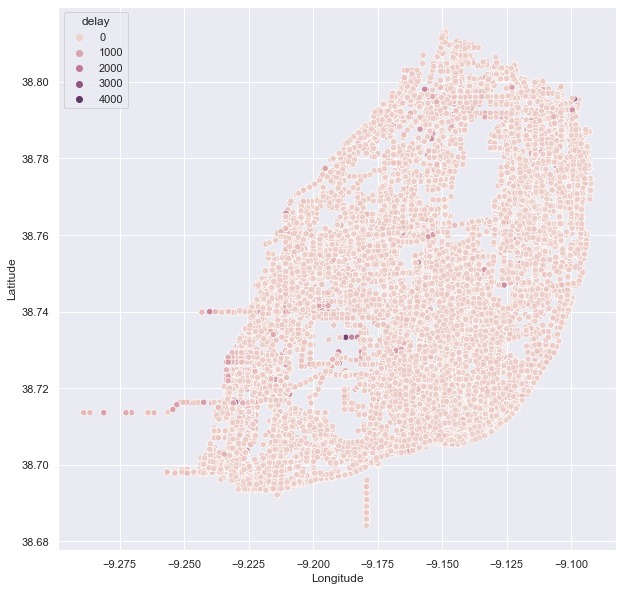

In [42]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=waze_data_ind_5000, y='Latitude', x='Longitude', hue='delay')

#### Grouping delay by street and minute 

In [17]:
waze_data_ind.groupby(['street', 'data_hora_2'])['delay'].mean().reset_index()

,street,data_hora_2,delay
0,2.ª Circular / Av. Cid. do Porto,2019-01-02 18:52:00,257.0
1,2.ª Circular / Av. Cid. do Porto,2019-01-02 18:57:00,305.0
2,2.ª Circular / Av. Cid. do Porto,2019-01-02 19:01:00,325.0
3,2.ª Circular / Av. Cid. do Porto,2019-01-02 19:05:00,395.0
4,2.ª Circular / Av. Cid. do Porto,2019-01-02 19:19:00,408.0
...,...,...,...
4457805,[Táxi],2019-08-31 09:02:00,99.0
4457806,[Táxi],2019-08-31 20:58:00,94.0
4457807,[Táxi],2019-09-01 19:18:00,138.0
4457808,[Táxi],2019-09-02 12:07:00,106.0


#### Grouping delay by coordinates 

In [18]:
Coord_group = waze_data_ind.groupby(['Coordinates', 'data_hora_2'])['delay'].mean().reset_index() 
Coord_group

,Coordinates,data_hora_2,delay
0,"38.684134,-9.179361",2019-01-02 17:18:00,233.0
1,"38.684134,-9.179361",2019-01-14 18:01:00,431.0
2,"38.684134,-9.179361",2019-01-14 18:07:00,490.0
3,"38.684134,-9.179361",2019-01-15 15:24:00,130.0
4,"38.684134,-9.179361",2019-01-15 15:29:00,174.0
...,...,...,...
6214463,"38.813206,-9.148628",2019-01-18 18:39:00,118.0
6214464,"38.813206,-9.148628",2019-05-06 07:50:00,225.0
6214465,"38.813206,-9.148628",2019-05-06 07:55:00,220.0
6214466,"38.813206,-9.148628",2019-05-06 08:01:00,212.0


In [68]:
Coord_group.to_csv(r'C:\Users\vfrad\Desktop\Faculdade\Pos_graduacao\Programming for Data Science\Projecto\Coord_group_delay.csv')

#### Grouping delay by h3 coordinate

In [19]:
H3Point_group=waze_data_ind.groupby(['H3_point', 'data_hora_2'])['delay'].mean().reset_index() 
H3Point_group

,H3_point,data_hora_2,delay
0,8839336013fffff,2019-01-02 16:28:00,52.0
1,8839336013fffff,2019-01-02 16:33:00,154.0
2,8839336013fffff,2019-01-02 17:00:00,218.0
3,8839336013fffff,2019-01-02 17:18:00,233.0
4,8839336013fffff,2019-01-14 17:46:00,303.0
...,...,...,...
3025323,88393375edfffff,2019-12-31 23:46:00,0.0
3025324,88393375edfffff,2019-12-31 23:50:00,0.0
3025325,88393375edfffff,2019-12-31 23:51:00,0.0
3025326,88393375edfffff,2019-12-31 23:55:00,0.0


In [70]:
H3Point_group.to_csv(r'C:\Users\vfrad\Desktop\Faculdade\Pos_graduacao\Programming for Data Science\Projecto\H3Point_group_delay.csv')

#### Grouping delay by minute (average delay for Lisbon in each minute) 

In [20]:
result = waze_data_ind.groupby(['data_hora_2'])['delay'].mean().reset_index()
result

,data_hora_2,delay
0,2019-01-01 00:02:00,24.088608
1,2019-01-01 00:07:00,36.827160
2,2019-01-01 00:13:00,42.801980
3,2019-01-01 00:17:00,37.134146
4,2019-01-01 00:22:00,31.530864
...,...,...
141924,2019-12-31 23:46:00,10.077670
141925,2019-12-31 23:50:00,9.946565
141926,2019-12-31 23:51:00,2.968750
141927,2019-12-31 23:55:00,9.045752


## 3. Intersecting traffic data with Accident data 
The idea in this section is try to find the correspondence between the accident ocurrence and the traffic level (delay value)  before and after the accident has occured.   

### 3.1 Import and create new features  
In this section the accident data is imported and then new features are created: 
-Calculate the h3 coordinates; 
-Obtain the time before and after accident occured, -10 and +20 minutes respectively.

In [21]:
Acidentes = pq.read_table(source='data_w_geolocation.parquet').to_pandas() 
Acidentes = Acidentes.reset_index() 
Acidentes

,index,data,latitude,longitude,tipo acidente
0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste
1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste
2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste
3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento
4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento
...,...,...,...,...,...
3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste
3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste
3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste
3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste


#### Getting the h3 coordinates of accident location

In [22]:
h3_point_Ac= list()
for i in range(0, Acidentes['latitude'].shape[0]):
    h3_point_Ac.insert(i, h3.geo_to_h3(Acidentes['latitude'][i], Acidentes['longitude'][i], 8)) 

In [23]:
Acidentes['H3_point'] = h3_point_Ac 
Acidentes['data-10min'] = Acidentes['data'] - timedelta(hours=0, minutes=10)  
Acidentes['data+20min'] = Acidentes['data'] + timedelta(hours=0, minutes=20)  

In [24]:
Acidentes

,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min
0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00
1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00
2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00
3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00
4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00
...,...,...,...,...,...,...,...,...
3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00
3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00
3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00
3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00


### 3.2 Intersection 
#### 3.2.1 Intersecting locations 

At this first phase we consider only the h3 locations that exist in both datasets, accident and traffic datasets

In [25]:
## Consider just the H3 coordinates that exist in both datasets
Intersect1 = H3Point_group['H3_point'].unique()
Intersect1=Intersect1.tolist() 
Intersect2 = Acidentes['H3_point'].unique()
Intersect2=Intersect2.tolist() 
A = list(set(Intersect2).intersection(Intersect1)) 
Acidentes= Acidentes.loc[Acidentes['H3_point'].isin(A)] 
Acidentes = Acidentes.reset_index() 
Acidentes

,level_0,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min
0,0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00
1,1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00
2,2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00
3,3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00
4,4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00
...,...,...,...,...,...,...,...,...,...
3603,3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00
3604,3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00
3605,3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00
3606,3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00


In [26]:
H3Point_group_aci = H3Point_group.loc[H3Point_group['H3_point'].isin(A)]  
H3Point_group_aci= H3Point_group_aci.reset_index()  

#### 3.2.1 Intersecting timings 
Since that delay's time registration may be different of the accident's time registration, in this procedure we searched for the most close datetime between the accident and traffic datasets (for the same h3 location). The target timings for this search were: the 10 minutes before and the 20 minutes after the accident occurence. After we find the closest datetime for those two moments in traffic dataset, we will extract the respective delay values for those two moments.  

#### Getting the closest datetime (and respective delay value) of the 10 minutes moment before the accident

In [27]:
data_hora_trans=[]    
delay_trans=[]    

for i in range(0, Acidentes.shape[0]): 
    x_points_group = H3Point_group_aci.loc[(H3Point_group_aci['H3_point'] == Acidentes['H3_point'][i])]
    x_points_group2 = x_points_group.set_index('data_hora_2')
    B=x_points_group2.index.get_loc(Acidentes['data-10min'][i], method='nearest') 
    x_points_group = x_points_group.reset_index()
    tempo = x_points_group['data_hora_2'][B]  
    atraso = x_points_group['delay'][B] 
    data_hora_trans.insert(i, tempo) 
    delay_trans.insert(i, atraso) 

In [28]:
Acidentes['Closest_Time-10min'] = data_hora_trans  
Acidentes['Closest_DelayTraffic-10min'] = delay_trans  
Acidentes

,level_0,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min,Closest_Time-10min,Closest_DelayTraffic-10min
0,0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00,2019-01-02 09:11:00,105.000000
1,1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00,2019-01-02 13:07:00,133.000000
2,2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00,2019-01-02 12:53:00,0.000000
3,3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00,2019-01-02 11:27:00,69.000000
4,4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00,2019-01-02 15:23:00,84.000000
...,...,...,...,...,...,...,...,...,...,...,...
3603,3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00,2019-12-30 13:12:00,92.000000
3604,3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00,2019-12-30 16:33:00,371.333333
3605,3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00,2019-12-30 19:13:00,99.000000
3606,3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00,2019-12-31 15:05:00,143.000000


#### Getting the closest datetime (and respective delay value) of the 20 minutes moment after the accident

In [29]:
data_hora_trans=[]    
delay_trans=[]    

for i in range(0, Acidentes.shape[0]): 
    x_points_group = H3Point_group_aci.loc[(H3Point_group_aci['H3_point'] == Acidentes['H3_point'][i])]
    x_points_group2 = x_points_group.set_index('data_hora_2')
    B=x_points_group2.index.get_loc(Acidentes['data+20min'][i], method='nearest') 
    x_points_group = x_points_group.reset_index()
    tempo = x_points_group['data_hora_2'][B]  
    atraso = x_points_group['delay'][B] 
    data_hora_trans.insert(i, tempo) 
    delay_trans.insert(i, atraso) 

Acidentes['Closest_Time+20min'] = data_hora_trans  
Acidentes['Closest_DelayTraffic+20min'] = delay_trans  
Acidentes

,level_0,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min,Closest_Time-10min,Closest_DelayTraffic-10min,Closest_Time+20min,Closest_DelayTraffic+20min
0,0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00,2019-01-02 09:11:00,105.000000,2019-01-02 09:11:00,105.0
1,1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00,2019-01-02 13:07:00,133.000000,2019-01-02 13:07:00,133.0
2,2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00,2019-01-02 12:53:00,0.000000,2019-01-02 13:28:00,0.0
3,3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00,2019-01-02 11:27:00,69.000000,2019-01-02 11:27:00,69.0
4,4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00,2019-01-02 15:23:00,84.000000,2019-01-02 15:28:00,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00,2019-12-30 13:12:00,92.000000,2019-12-30 13:22:00,85.0
3604,3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00,2019-12-30 16:33:00,371.333333,2019-12-30 17:03:00,278.2
3605,3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00,2019-12-30 19:13:00,99.000000,2019-12-30 19:13:00,99.0
3606,3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00,2019-12-31 15:05:00,143.000000,2019-12-31 15:44:00,108.0


#### 3.2.2 Cleaning Intersection 
If we read some of the results of dataframe above, we will observe that in several cases the closest datetime of the accident timings (10 minutes before, the accident moment and 20 minutes after) is way before or way after of those crucial moments. Therefore, we conclude that if there is no registration of traffic values in timings relevantly closed to the accident moments, probably there was no traffic at all in those moments, and so we considered the delay values as zero.  

In [30]:
## Changing the delay values to zero accordingly with the criteria described above
Acidentes.loc[Acidentes['Closest_Time-10min']>Acidentes['data'], 'Closest_DelayTraffic-10min']=0  
Acidentes.loc[Acidentes['Closest_Time-10min']<Acidentes['data-10min']-timedelta(hours=2, minutes=0), 'Closest_DelayTraffic-10min']=0 

Acidentes.loc[Acidentes['Closest_Time+20min']<Acidentes['data'], 'Closest_DelayTraffic+20min']=0  
Acidentes.loc[Acidentes['Closest_Time+20min']>Acidentes['data+20min']+timedelta(hours=4, minutes=0) , 'Closest_DelayTraffic+20min']=0

Acidentes

,level_0,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min,Closest_Time-10min,Closest_DelayTraffic-10min,Closest_Time+20min,Closest_DelayTraffic+20min
0,0,0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00,2019-01-02 09:11:00,105.000000,2019-01-02 09:11:00,0.0
1,1,1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00,2019-01-02 13:07:00,0.000000,2019-01-02 13:07:00,133.0
2,2,2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00,2019-01-02 12:53:00,0.000000,2019-01-02 13:28:00,0.0
3,3,3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00,2019-01-02 11:27:00,0.000000,2019-01-02 11:27:00,0.0
4,4,4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00,2019-01-02 15:23:00,84.000000,2019-01-02 15:28:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,3615,1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00,2019-12-30 13:12:00,92.000000,2019-12-30 13:22:00,0.0
3604,3616,1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00,2019-12-30 16:33:00,371.333333,2019-12-30 17:03:00,278.2
3605,3617,1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00,2019-12-30 19:13:00,99.000000,2019-12-30 19:13:00,0.0
3606,3618,1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00,2019-12-31 15:05:00,143.000000,2019-12-31 15:44:00,108.0


#### The intersection is concluded and it is created a csv file with cleaned information

In [31]:
Acidentes.to_csv(r'C:\Users\vfrad\Desktop\Faculdade\Pos_graduacao\Programming for Data Science\Projecto\Accidents_with_traffic_v3.csv')

## 4. Traffic Statistics
In this section it will be performed a simple quantitative analysis/ exploration in order to briefly characterize the traffic in Lisbon. 

<AxesSubplot:xlabel='delay', ylabel='Count'>

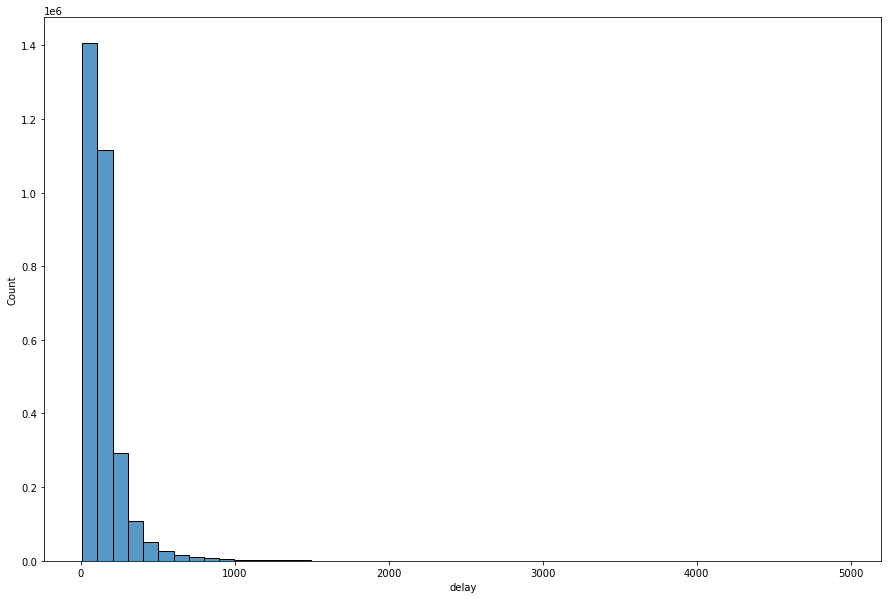

In [19]:
fig= plt.subplots(figsize = (15,10)) 
sns.histplot(x= 'delay', data = waze_data_ind_5000, bins = 50)

### 4.1 Evaluate the hourly profile of Lisbon

In [43]:
waze_data_hour_5000= waze_data_ind_5000.groupby(['Hours'])['delay'].mean().reset_index() 
waze_data_hour_5000.sort_values(by='Hours', ascending=True).reset_index()

,index,Hours,delay
0,0,0,24.963754
1,1,1,19.431447
2,2,2,15.365012
3,3,3,11.468624
4,4,4,9.219696
5,5,5,9.255641
6,6,6,14.788181
7,7,7,65.892917
8,8,8,94.859332
9,9,9,78.278742


<AxesSubplot:xlabel='Hours', ylabel='delay'>

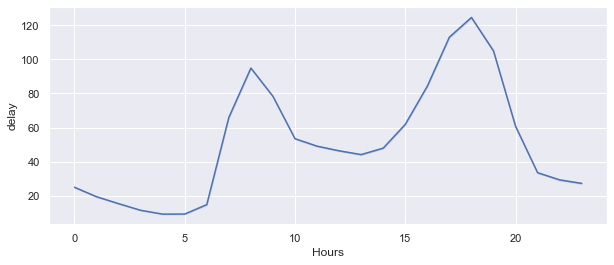

In [44]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=waze_data_ind_5000, y='delay', x='Hours')

### 4.2 Evaluate the hourly profile of Lisbon in each month

[Text(0.5, 1.0, 'December')]

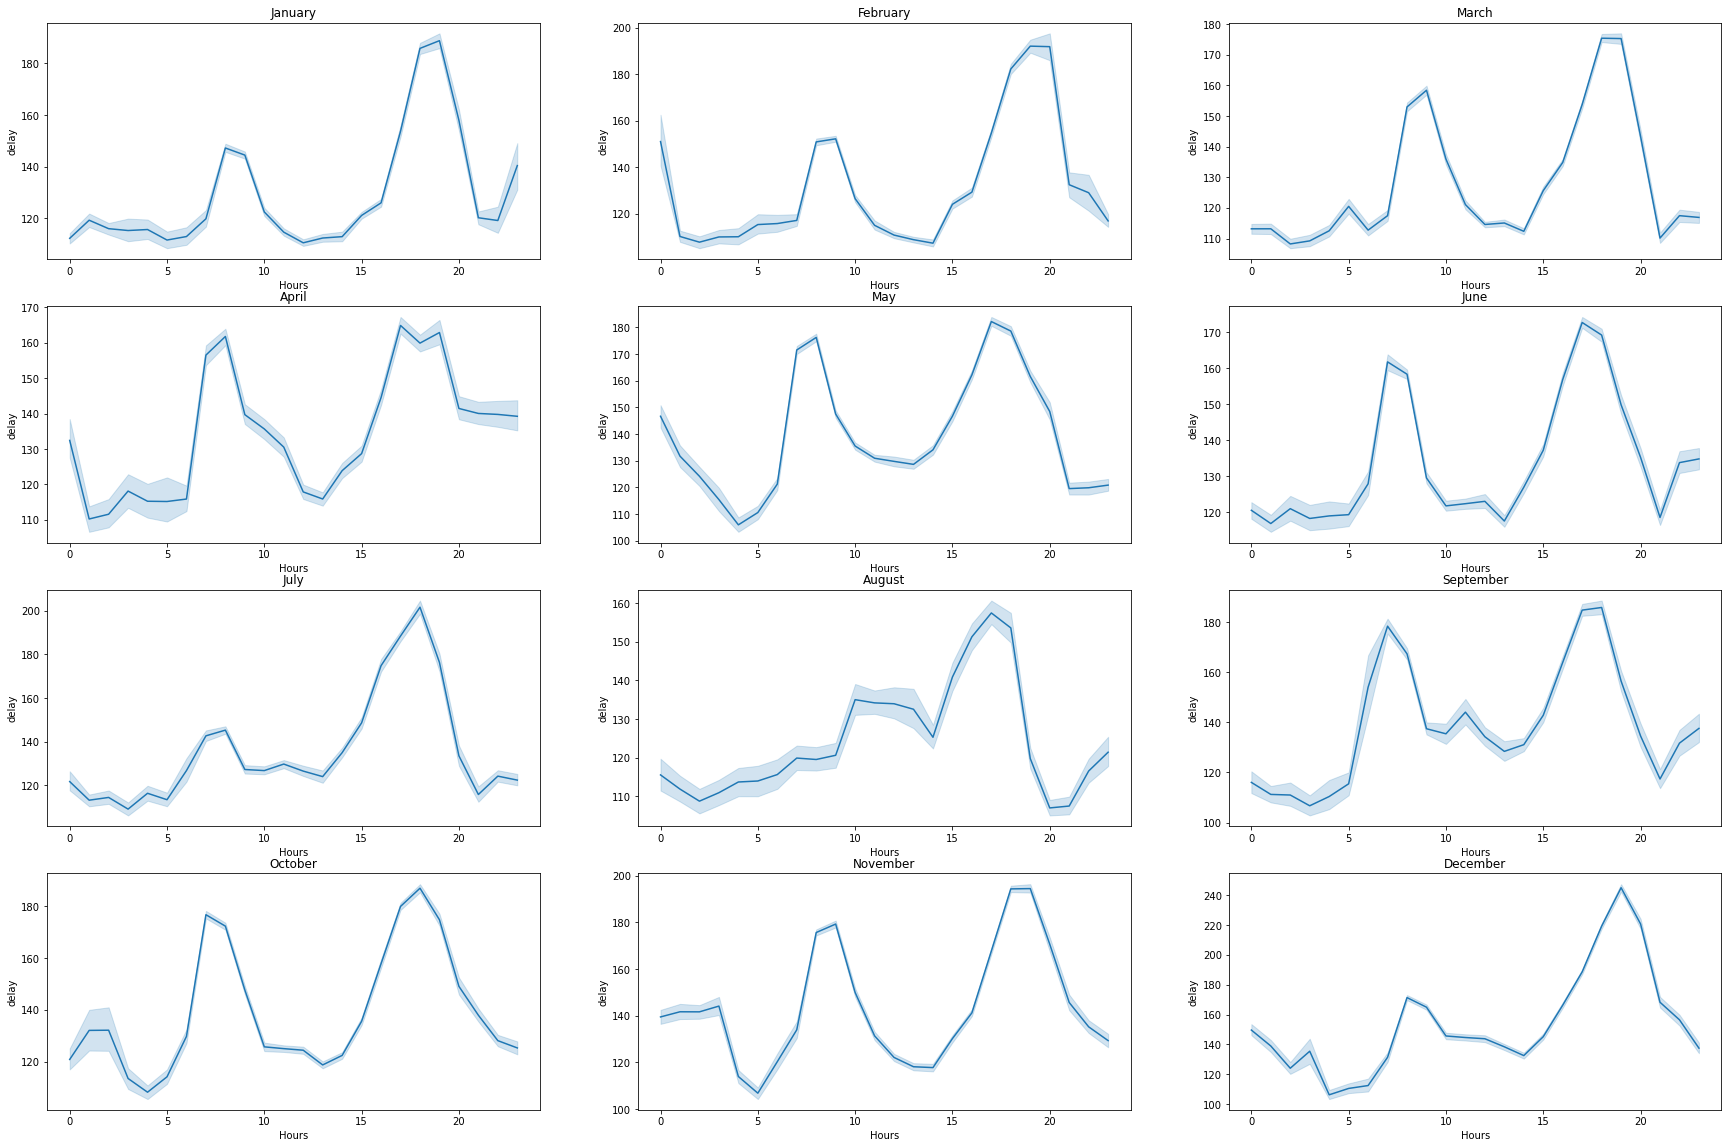

In [40]:
fig, axes = plt.subplots(4,3, figsize = (30,20))
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==1)], y='delay', x='Hours', ax = axes[0,0]).set(title='January')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==2)], y='delay', x='Hours', ax = axes[0,1]).set(title='February')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==3)], y='delay', x='Hours', ax = axes[0,2]).set(title='March')

sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==4)], y='delay', x='Hours', ax = axes[1,0]).set(title='April')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==5)], y='delay', x='Hours', ax = axes[1,1]).set(title='May')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==6)], y='delay', x='Hours', ax = axes[1,2]).set(title='June')

sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==7)], y='delay', x='Hours', ax = axes[2,0]).set(title='July')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==8)], y='delay', x='Hours', ax = axes[2,1]).set(title='August')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==9)], y='delay', x='Hours', ax = axes[2,2]).set(title='September')

sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==10)], y='delay', x='Hours', ax = axes[3,0]).set(title='October')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==11)], y='delay', x='Hours', ax = axes[3,1]).set(title='November')
sns.lineplot(data=waze_data_ind_5000.loc[(waze_data_ind_5000['Months']==12)], y='delay', x='Hours', ax = axes[3,2]).set(title='December')


<AxesSubplot:xlabel='Hours', ylabel='delay'>

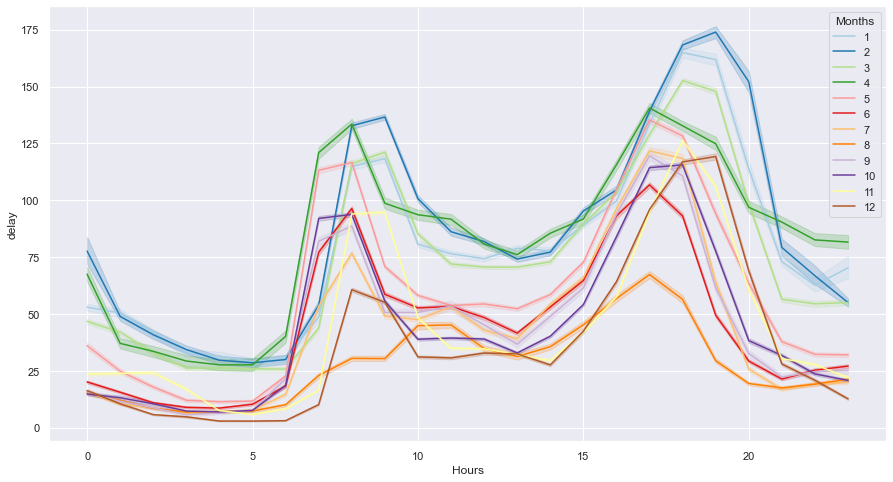

In [45]:
custom_palette = sns.color_palette("Paired", 12)
plt.figure(figsize=(15, 8)) 
sns.lineplot(data=waze_data_ind_5000, y='delay', x='Hours', hue= "Months", palette=custom_palette) 

In [ ]:
waze_data_street_5000= waze_data_ind_5000.groupby(['Months'])['delay'].mean().reset_index() 
waze_data_street_5000.sort_values(by='Months', ascending=True).reset_index().transpose()

### 4.3. Getting the streets with higher traffic values

In [47]:
waze_data_street_5000= waze_data_ind_5000.groupby(['street'])['delay'].mean().reset_index() 
waze_data_street_5000.sort_values(by='delay', ascending=False).reset_index()

,index,street,delay
0,57,"Ac. 2ª Circular {O}, IC19",910.222222
1,970,Pç. de S. João,819.500000
2,2847,Tv. da Nazaré,664.500000
3,212,"Ac. IC17 CRIL, A1 {N}, Aeroporto",642.900000
4,113,"Ac. A1 {N}, Alverca",624.908284
...,...,...,...
2948,2423,R. da Rainha das Ilhas das Cobras,0.000000
2949,2424,R. da Regueira,0.000000
2950,1715,R. Jaime Santos,0.000000
2951,1726,R. Joaquina,0.000000
